In [64]:
# torch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.transforms import transforms
import torch.optim as optim
# utils
import os
from glob import glob
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
# visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, confusion_matrix

In [66]:
# global variables
device = "cuda" if torch.cuda.is_available() else "cpu"

dataset_path = "./ppi_dataset"
train_path = "./ppi_dataset/train"
valid_path = "./ppi_dataset/valid"
test_path = "./ppi_dataset/test"
image_size = (224,224)
num_classes = 3
train_paths = glob(f"{train_path}/*/*.jpg")
valid_paths = glob(f"{valid_path}/*/*.jpg")
test_paths = glob(f"{test_path}/*/*.jpg")

In [67]:
train_path

'./ppi_dataset/train'

In [68]:
train_paths, valid_paths, test_paths

(['./ppi_dataset/train\\flat foot\\image_0016_png_jpg.rf.f7fc68ea152c14f2ae879c1cba7df55a.jpg',
  './ppi_dataset/train\\flat foot\\image_0020_png_jpg.rf.d6d96148221423a2161a0defcb7578e8.jpg',
  './ppi_dataset/train\\flat foot\\image_0020_png_jpg.rf.eb98f3702c7f5713e1e89915b229e45b.jpg',
  './ppi_dataset/train\\flat foot\\image_0022_png_jpg.rf.2b84efbe23c3d3d96817dc4f2c6ce1b3.jpg',
  './ppi_dataset/train\\flat foot\\image_0022_png_jpg.rf.324b5b2f55291b85a4fad1d713d178ae.jpg',
  './ppi_dataset/train\\flat foot\\image_0025_png_jpg.rf.4c81bb662bf227770ed33777c290b329.jpg',
  './ppi_dataset/train\\flat foot\\image_0032_png_jpg.rf.6ea8171e7e1c336e74f31914e16052b3.jpg',
  './ppi_dataset/train\\flat foot\\image_0036_png_jpg.rf.0a9ae49e48a523c46b1c22624226e5e6.jpg',
  './ppi_dataset/train\\flat foot\\image_0041_png_jpg.rf.0a0dbcbb834908087ceeb480b38cc42e.jpg',
  './ppi_dataset/train\\flat foot\\image_0059_png_jpg.rf.94e99643537df5fada9ae70121c18bfd.jpg',
  './ppi_dataset/train\\flat foot\\image

In [69]:
len(train_paths), len(valid_paths), len(test_paths)

(1213, 341, 179)

In [70]:
# check device
device

'cuda'

In [71]:
# data augmentation
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10),
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [72]:
# custom dataset class
class dataset(Dataset):
    def __init__(self,paths,transform=None):
        self.paths = paths
        self.transform = transform
        self.labels = [self.get_label(path) for path in self.paths]
        self.labels_to_index = {label:index for index,label in enumerate(list(set(self.labels)))}
        
        print(self.labels)
        print(self.labels_to_index)
    
    def __getitem__(self,index):
        img_path = self.paths[index]
        img = Image.open(img_path).convert('RGB') 
        label = self.labels[index]
        label_index = self.labels_to_index[label]
        
        if self.transform:
            img = self.transform(img)
        
        return img, label_index,label
    
    
    def __len__(self):
        return len(self.paths)
    
    
    def get_label(self, path):
        return os.path.basename(os.path.dirname(path))

In [73]:
train_dataset = dataset(train_paths, transform=train_transform)
valid_dataset = dataset(valid_paths, transform=train_transform)
test_dataset = dataset(test_paths, transform=test_transform)

['flat foot', 'flat foot', 'flat foot', 'flat foot', 'flat foot', 'flat foot', 'flat foot', 'flat foot', 'flat foot', 'flat foot', 'flat foot', 'flat foot', 'flat foot', 'flat foot', 'flat foot', 'flat foot', 'flat foot', 'flat foot', 'flat foot', 'flat foot', 'flat foot', 'flat foot', 'flat foot', 'flat foot', 'flat foot', 'flat foot', 'flat foot', 'flat foot', 'flat foot', 'flat foot', 'flat foot', 'flat foot', 'flat foot', 'flat foot', 'flat foot', 'flat foot', 'flat foot', 'flat foot', 'flat foot', 'flat foot', 'flat foot', 'flat foot', 'flat foot', 'flat foot', 'flat foot', 'flat foot', 'flat foot', 'flat foot', 'flat foot', 'flat foot', 'flat foot', 'flat foot', 'flat foot', 'flat foot', 'flat foot', 'flat foot', 'flat foot', 'flat foot', 'flat foot', 'flat foot', 'flat foot', 'flat foot', 'flat foot', 'flat foot', 'flat foot', 'flat foot', 'flat foot', 'flat foot', 'flat foot', 'flat foot', 'flat foot', 'flat foot', 'flat foot', 'flat foot', 'flat foot', 'flat foot', 'flat foot'

In [74]:
train_dataset.__len__(), valid_dataset.__len__(), test_dataset.__len__()

(1213, 341, 179)

In [75]:
test_path = './ppi_dataset/test/flat foot/image_0020_png_jpg.rf.f837a01d350622ee5a66471c82bb995d.jpg'
train_dataset.get_label(test_path)

'flat foot'

In [76]:
# val_dataset, test_dataset = train_test_split(test_dataset,test_size=0.5, random_state=ord("H"))

In [77]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [95]:
len(train_loader.dataset), len(val_loader.dataset), test_loader.batch_size

(1213, 341, 32)

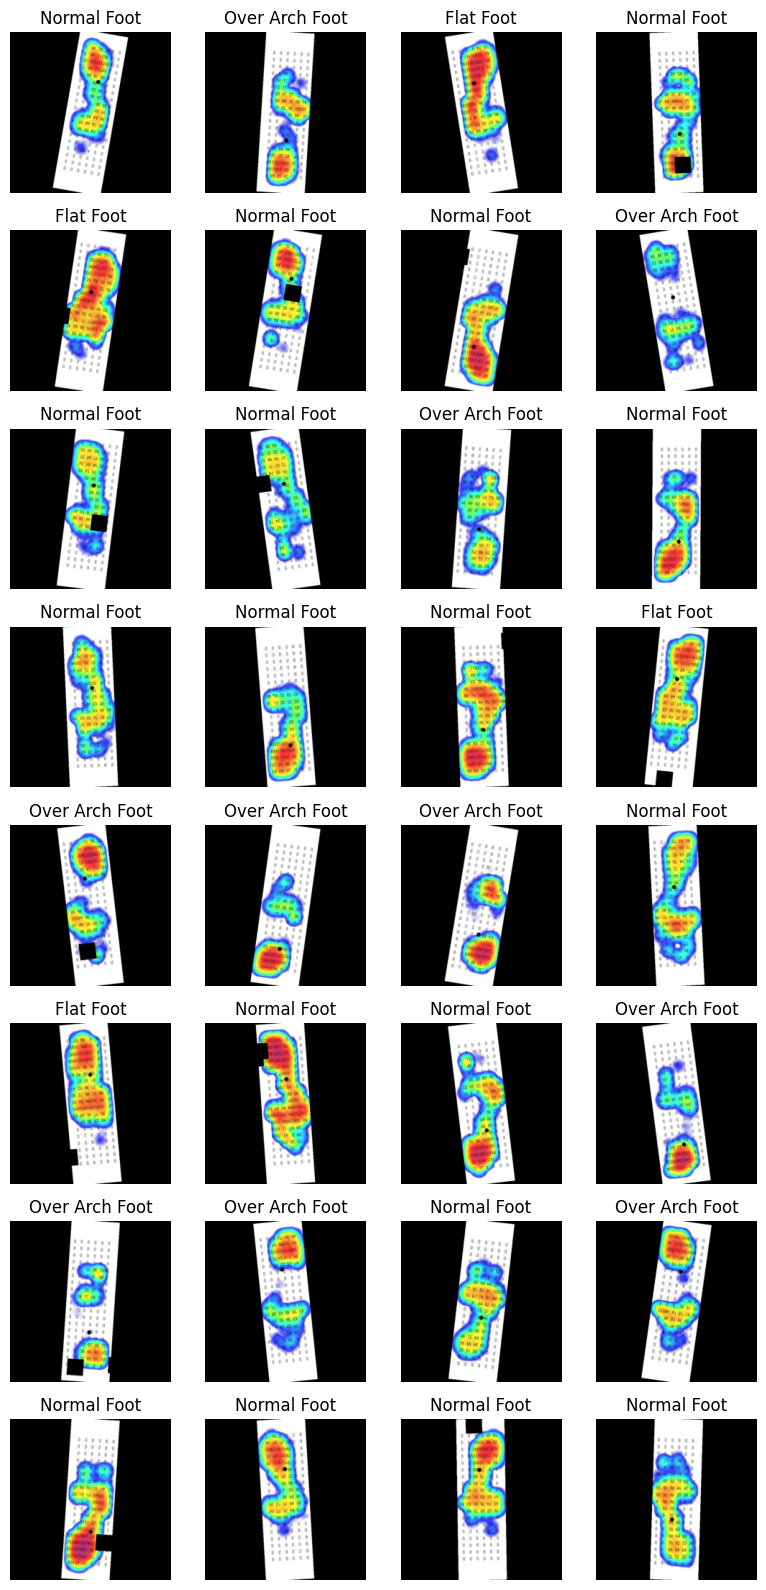

In [79]:
# display sample images with classes
train_iter = iter(train_loader)
images, labels_indices, labels = next(train_iter)

def imshow(input_images, labels_indices,labels):
    label_dict = {"normal":"Normal Foot", "flat foot":"Flat Foot", "over-arch":"Over Arch Foot"}
    input_images=input_images.numpy().transpose((0, 2, 3, 1))  # 차원 index, 원래: [B, C, H, W] -> 바꾼 후: [B, H, W, C]

    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    input_images = std * input_images + mean
    input_images = np.clip(input_images, 0, 1)
    fig, axes = plt.subplots(8, 4, figsize=(8, 16))
    for i, ax in enumerate(axes.flat):
        ax.imshow(input_images[i])
        ax.axis('off')
        ax.set_title(label_dict[labels[i]], fontsize=12)
    plt.tight_layout()
    plt.show()


imshow(images, labels_indices,labels)

In [80]:
class MyModel(nn.Module):
    def __init__(self,num_classes):
        super(MyModel,self).__init__()
        
        self.conv1 = nn.Conv2d(3,32,kernel_size=4,stride=1,padding=0)
        self.bn1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(32,64,kernel_size=4,stride=1,padding=0)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(64,128,kernel_size=4,stride=1,padding=0)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.conv4 = nn.Conv2d(128,128,kernel_size=4,stride=1,padding=0)
        self.bn4 = nn.BatchNorm2d(128)
        
        self.pool = nn.MaxPool2d(kernel_size=3, stride=3)
        self.pool2= nn.MaxPool2d(kernel_size=3, stride=2)
        
        self.fc1 = nn.Linear(6*6*128,512)
        self.fc2 = nn.Linear(512,num_classes)
        
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU() 
        self.dropout = nn.Dropout(0.5)
        
        
    def forward(self,x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.pool2(x)
        x = self.relu(self.bn4(self.conv4(x)))
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [81]:
model = MyModel(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.0002)

In [82]:
def train_epoch():
    model.train()
    total_loss = 0.0 
    total_correct = 0
    total_predictions = 0
    
    for batch_number, (images, labels_indices, labels) in enumerate(train_loader):
        images, labels_indices = images.to(device), labels_indices.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(images)
        loss = criterion(outputs, labels_indices)
        total_loss += loss.item()
        
        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        total_predictions += labels_indices.size(0)
        total_correct += (predicted == labels_indices).sum().item()
        
        loss.backward()
        optimizer.step()
        
        if (batch_number and batch_number % 150 == 0):
            c_loss = total_loss / (batch_number + 1)
            accuracy = total_correct / total_predictions
            print(f"Batch {batch_number}/{len(train_loader)}, Loss: {c_loss:0.4f}, Accuracy: {accuracy * 100:.2f}%")
    
    avg_loss = total_loss / len(train_loader)
    avg_accuracy = total_correct / total_predictions
    
    return avg_loss, avg_accuracy


In [83]:
def eval_model():
    model.eval()
    total_loss = 0.0 
    total_correct = 0
    total_predictions = 0
    
    with torch.no_grad():
        for batch_number, (images, labels_indices, labels) in enumerate(val_loader):
            images, labels_indices = images.to(device), labels_indices.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels_indices)
            total_loss += loss.item()
            
            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)  # max_vals, max_indices
            total_predictions += labels_indices.size(0)
            total_correct += (predicted == labels_indices).sum().item()
            
    avg_loss = total_loss / len(val_loader)
    avg_accuracy = total_correct / total_predictions
    
    return avg_loss, avg_accuracy


In [84]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

In [85]:
best_score = float("inf")
n_epochs = 30
tolerance = 0

for epoch in range(n_epochs):
    print(f"Epoch {epoch},   ", end="")
    avg_train_loss, train_accuracy = train_epoch()
    avg_eval_loss, eval_accuracy = eval_model()
    
    if avg_eval_loss < best_score:
        best_score = avg_eval_loss
        torch.save(model.state_dict(), f"./models/model_{epoch+1}")
        tolerance = 0
    else:
        tolerance += 1
        if tolerance >= 8:
            break
            
    train_losses.append(avg_train_loss)
    val_losses.append(avg_eval_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(eval_accuracy)
    
    print(f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy * 100:.2f}%")
    print(f"Eval Loss: {avg_eval_loss:.4f}, Eval Accuracy: {eval_accuracy * 100:.2f}%")
    print("#" * 70)


Epoch 0,   Train Loss: 0.6807, Train Accuracy: 69.33%
Eval Loss: 0.3895, Eval Accuracy: 85.63%
######################################################################
Epoch 1,   Train Loss: 0.3198, Train Accuracy: 87.06%
Eval Loss: 0.2666, Eval Accuracy: 89.44%
######################################################################
Epoch 2,   Train Loss: 0.2764, Train Accuracy: 89.28%
Eval Loss: 0.4267, Eval Accuracy: 83.87%
######################################################################
Epoch 3,   Train Loss: 0.2611, Train Accuracy: 88.79%
Eval Loss: 0.4996, Eval Accuracy: 82.11%
######################################################################
Epoch 4,   Train Loss: 0.2281, Train Accuracy: 91.01%
Eval Loss: 0.6111, Eval Accuracy: 78.01%
######################################################################
Epoch 5,   Train Loss: 0.2292, Train Accuracy: 90.85%
Eval Loss: 0.4413, Eval Accuracy: 86.22%
######################################################################
Epoc

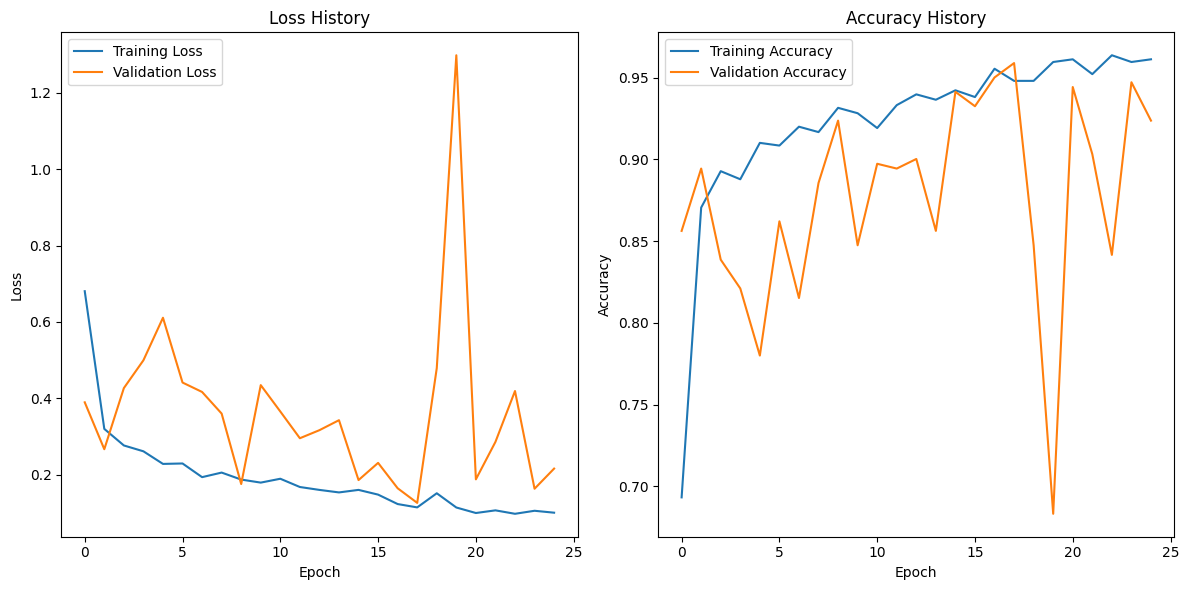

In [94]:
# Visualize training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss History')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy History')

plt.tight_layout()
plt.show()

In [87]:
models = glob("./models/*")
model_num = [int(i.split("_")[-1]) for i in models if i.split("_")[-1].isdigit()]
best_model_path = f"./models/model_{sorted(model_num)[-1]}"
best_model_path

'./models/model_18'

In [88]:
best_model = MyModel(num_classes).to(device)
best_model.load_state_dict(torch.load(best_model_path, map_location=device))
best_model

MyModel(
  (conv1): Conv2d(3, 32, kernel_size=(4, 4), stride=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(4, 4), stride=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 128, kernel_size=(4, 4), stride=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4608, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=3, bias=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, in

In [89]:
def predict(
    model:nn.Module, 
    sample_loader:torch.utils.data.DataLoader,
    device:torch.device) -> np.ndarray:
    
    model.eval()
    predictions = []
    with torch.inference_mode():
        for batch, (X, y,labels) in enumerate(sample_loader):
            X, y = X.to(device), y.to(device)
            y_pred = model(X) 
            predictions.append(y_pred.cpu().numpy())
        
    return np.vstack(predictions)

In [90]:
best_model_props = predict(best_model, test_loader, device)
best_model_preds = np.argmax(best_model_props, axis=1)
best_model_preds.shape[0]

179

In [91]:
gen_labels_test_set = [label[1] for label in test_dataset]
len(gen_labels_test_set)

179

In [92]:
print(f"Best Model Test Accuracy: {round(accuracy_score(gen_labels_test_set,best_model_preds)*100,2)}%")

Best Model Test Accuracy: 90.5%


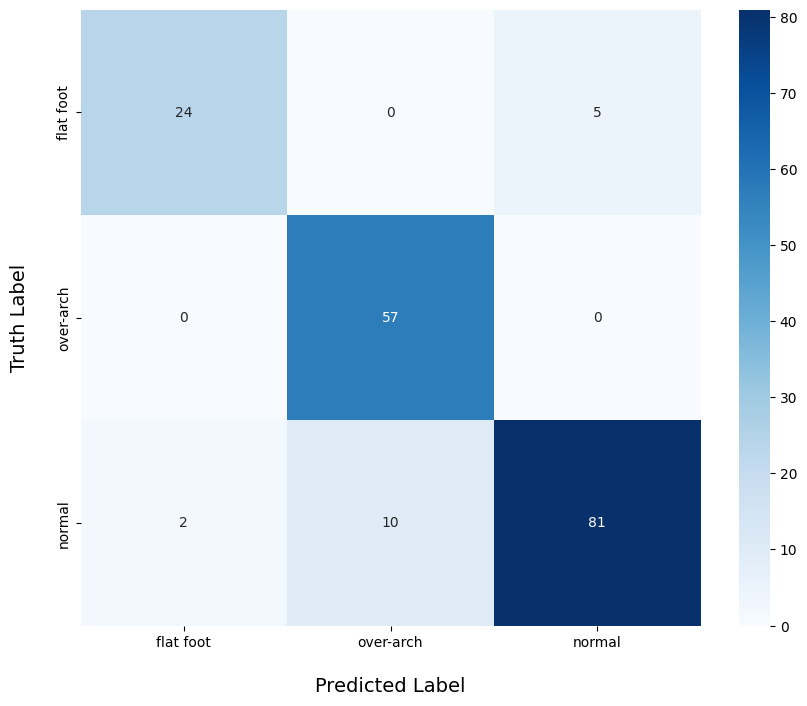

In [93]:
cm = confusion_matrix(gen_labels_test_set, best_model_preds)
labels = set([label[2] for label in test_dataset])
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label', labelpad=20, fontsize=14)
plt.ylabel('Truth Label', labelpad=20, fontsize=14)
plt.show()